In [1]:
%cd ../../

import os 
import logging
import time
import random
from datetime import datetime
from livelossplot import outputs
import tensorflow as tf
import numpy as np
from numpy import load, zeros, ones
from numpy.random import randint
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, LeakyReLU, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, Concatenate
from tensorflow.keras import losses
from tensorflow.keras import metrics 
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.math import multiply, add, subtract
from matplotlib import pyplot
from tensorflow.python.autograph.pyct import transformer
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import config


e:\Data Science\Projects\intelli style transfer\STGAN


In [2]:

# set logger
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

#tensorboard logger
logdir = config.LOG_DIR+ "/gan_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch=1)



In [3]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g

def defing_generator(latent_size, image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    content_image = Input(shape=image_shape)
    style_image = Input(shape=image_shape)
    # stack content and style images
    stacked_layer = Concatenate()([content_image, style_image])
    #encoder model
    e1 = define_encoder_block(stacked_layer, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e6)
    b = ReLU()(b)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(b, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    #output layer
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(inputs=[content_image, style_image], outputs=out_image, name='generator')
    return model

g_model = defing_generator(config.GAN_LATENT_SIZE, config.IMAGE_SHAPE)
#tf.keras.utils.plot_model(g_model, show_shapes=True)

def define_cnt_descriminator(image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    #content image input
    in_cnt_image = Input(shape=image_shape)
    #transfer image input 
    in_tr_image = Input(shape=image_shape)
    #concatnate image channel-wise
    merged = Concatenate()([in_cnt_image, in_tr_image])
    # c64
    d = Conv2D(64, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # c128
    d = Conv2D(128, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c256
    d = Conv2D(256, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c512
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    #define model
    model = Model(inputs=[in_cnt_image, in_tr_image], outputs=patch_out, name='content_descriminator')
    return model

dc_model = define_cnt_descriminator()
#tf.keras.utils.plot_model(dc_model, show_shapes=True)


def define_style_descriminator(image_size=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    input_img = Input(shape=image_size)
    # C64
    d = Conv2D(64, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(input_img)
    d = LeakyReLU(alpha=0.2)(d)
	# C128
    d = Conv2D(128, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	# C256
    d = Conv2D(256, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # flatten
    flt = Flatten()(d)
    # linear logits layer
    output = Dense(1)(flt)
    #build and compile the model
    model = Model(inputs=input_img, outputs=output, name='style_descriminator')
    return model

ds_model = define_style_descriminator()
#tf.keras.utils.plot_model(ds_model, show_shapes=True)


def define_gan(g_model, dc_model, ds_model, image_shape=(128, 128, 3)):
    for layer in dc_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    
    for layer in ds_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # input layer for GAN model
    cnt_img = Input(shape=image_shape)
    style_img = Input(shape=image_shape)
    # generator model
    gen_out = g_model([cnt_img, style_img])
    # style descriminator model
    dss_out = ds_model(style_img)
    dst_out = ds_model(gen_out)
    # content descriminator model
    cnt_out = dc_model([cnt_img, gen_out])
    model = Model(inputs=[cnt_img, style_img], outputs=[gen_out,  dss_out, dst_out, cnt_out])
    return model

gan_model = define_gan(g_model, dc_model, ds_model)
#tf.keras.utils.plot_model(gan_model, show_shapes=True)


def pairWiseRankingLoss(y_ref, y_style, label):
    m  = tf.cast(tf.broadcast_to(1, shape=y_ref.shape), dtype=tf.float32)
    u  = tf.cast(tf.broadcast_to(0, shape=y_ref.shape), dtype=tf.float32)
    i  = tf.cast(tf.broadcast_to(1, shape=y_ref.shape), dtype=tf.float32)
    y = tf.cast(label[..., tf.newaxis], dtype=tf.float32)
    dist = tf.norm(y_ref-y_style, ord='euclidean', axis=-1, keepdims=True)
    loss = y*dist + (i-y)*tf.reduce_max(tf.stack([u,m-dist]), axis=0)
    return tf.cast(tf.reduce_mean(loss), dtype=tf.float32)

def ganLoss(dss_loss, dsc_loss, gen_loss):
    gan_alpha = config.GAN_ALPHA
    gan_beta = config.GAN_BETA
    one = 1

    tot_loss = gan_alpha*(gan_beta*dss_loss+(one-gan_beta)*dsc_loss)+(one-gan_alpha)*gen_loss
    return tot_loss

dscLoss = tf.keras.losses.BinaryCrossentropy()
cntLoss = tf.keras.losses.MeanSquaredError()

gan_opt = tf.keras.optimizers.Adamax(lr=0.002)


@tf.function
def gan_train_step(ref_in, style_in, trans_in,cnt_true, style_true):
    with tf.GradientTape() as tape:
        gen_out, dss_out, dst_out, cnt_out = gan_model([ref_in, style_in])
        dss_loss = pairWiseRankingLoss(dss_out, dst_out, style_true)
        dsc_loss = tf.cast(dscLoss(cnt_true, cnt_out), dtype=tf.float32)
        gen_loss = tf.cast(tf.math.abs(cntLoss(trans_in, gen_out)), dtype=tf.float32)
        total_loss = ganLoss(dss_loss, dsc_loss, gen_loss)
        
    #total_loss = add(add(multiply(gan_beta, dss_loss), multiply(subtract(one, gan_beta), dsc_loss)), multiply(subtract(one, gan_alpha), gen_loss))    
    #total_loss =  gan_alpha*(gan_beta*dss_loss+(one-gan_beta)*dsc_loss)+(one-gan_alpha)*gen_loss
    grads = tape.gradient(total_loss, gan_model.trainable_weights)
    gan_opt.apply_gradients(zip(grads, gan_model.trainable_weights))
    return total_loss, dss_loss, dsc_loss, gen_loss

ds_opt = tf.keras.optimizers.Adam(lr=0.02)

@tf.function
def ds_train_step(style_in, trans_in, label_in):
    with tf.GradientTape() as tape:
        ref_out = ds_model(style_in)
        trans_out = ds_model(trans_in)
        loss = pairWiseRankingLoss(ref_out, trans_out, label_in)
    grads = tape.gradient(loss, ds_model.trainable_weights)
    ds_opt.apply_gradients(zip(grads, ds_model.trainable_weights))
    #train_metrics.update_state(ref_out, style_out, label_in)
    return loss


dc_opt = tf.keras.optimizers.Adam(lr=0.02)

@tf.function
def dc_train_step(cnt_in, trans_in, label_in):
    with tf.GradientTape() as tape:
        logits = dc_model([cnt_in, trans_in])
        loss = cntLoss(label_in, logits)
    grads = tape.gradient(loss, dc_model.trainable_weights)
    dc_opt.apply_gradients(zip(grads, dc_model.trainable_weights))
    #train_metrics.update_state(ref_out, style_out, label_in)
    return loss


def load_pixel_metrics(filename):
    full_mat = np.load(filename)
    style_pixels = (full_mat['style']-127.5)/127.5
    content_pixels = (full_mat['cotent']-127.5)/127.5
    transfer_mat  = (full_mat['transfers']-127.5)/127.5
    return style_pixels, content_pixels, transfer_mat

def generate_real_samples(dataset, n_samples, patch_shape):
    style, content, trans = dataset
    cnt_idxs = random.sample(range(style.shape[1]), n_samples)
    style_idxs = np.random.randint(0, style.shape[0], n_samples)

    cnt_pixels = content[cnt_idxs]
    style_pixels = style[style_idxs]
    mat_pixels = trans[style_idxs, cnt_idxs, ...]

    y_dc = ones((n_samples, patch_shape, patch_shape, 1))
    y_ds = ones((n_samples))
    return [cnt_pixels, style_pixels, mat_pixels], y_dc, y_ds

def generate_fake_samples(g_model, samples, patch_shape):
    cnt_img, style_img = samples
    X = g_model([cnt_img, style_img])
    y_dc = zeros((len(X), patch_shape, patch_shape, 1))
    y_ds = zeros((len(X)))
    return X, y_dc, y_ds

def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_cnt, X_stl, X_trn], _, _ = generate_real_samples(dataset, n_samples, 1)
    X_fake, _, _ = generate_fake_samples(g_model, [X_cnt, X_stl], 1)
    #rescale pixels values
    X_cnt = (X_cnt+1)/2.0
    X_stl = (X_stl+1)/2.0
    X_fake = (X_fake+1)/2.0
    # plot samples
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_cnt[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_stl[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + 2*n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fake[i])
    # save result image 
    filename = f'plot_{step+1}.png'
    pyplot.savefig(os.path.join(config.GAN_LOG_DIR,filename))
    pyplot.close()
    # save model checkpoint
    model_filename = f'model_{step+1}.h5'
    g_model.save(os.path.join(config.GAN_LOG_DIR,model_filename))
    logger.info(f">> Saved : {filename} , {model_filename} ")


def train(g_model, dataset, n_epoch=100, batch_size=16):
    n_patch = dc_model.output_shape[1]
    batch_per_epoch = (dataset[1].shape[0]*(dataset[1].shape[1]//2))//batch_size
    n_steps = n_epoch*batch_per_epoch
    plotlosses = PlotLosses(outputs=[MatplotlibPlot()], groups={'dss model' : ['dss_loss'], 'dsc model' : ['dsc_loss'], 'gan model' : ['total_loss', 'gen_loss', 'gans_loss', 'ganc_loss']})

    save_interval = 10
    log_interval = 1

    for i in range(n_steps):
        [X_cnt, X_stl, X_trn], ydc_real, yds_real = generate_real_samples(dataset, batch_size, n_patch)
        X_fake_trn, ydc_fake, yds_fake = generate_fake_samples(g_model, [X_cnt, X_stl], n_patch)
        # train style descriminator
        usXds_stl = np.concatenate((X_stl, X_stl))
        usXds_trn = np.concatenate((X_trn, X_fake_trn))
        usysd = np.concatenate((yds_real, yds_fake))
        Xds_stl, Xds_trn, yds = shuffle(usXds_stl, usXds_trn, usysd)
        ds_loss = ds_train_step(Xds_stl, Xds_trn, yds)
        #ds_loss2 = ds_train_step(X_stl, X_fake_trn, yds_fake)
        #train content descriminator
        usXdc_cnt = np.concatenate((X_cnt, X_cnt))
        usXdc_trn = np.concatenate((X_trn, X_fake_trn))
        usydc = np.concatenate((ydc_real, ydc_fake))
        Xdc_cnt, Xdc_trn, ydc = shuffle(usXdc_cnt, usXdc_trn, usydc)
        dc_loss = dc_train_step(Xdc_cnt, Xdc_trn, ydc)
        #dc_loss2 = dc_train_step(X_cnt, X_fake_trn, ydc_fake)
        #train GAN model
        gan_total_loss, gan_dss_loss, gan_dsc_loss, gen_loss = gan_train_step(X_cnt, X_stl, X_trn, ydc_real, yds_real)

        logger.info(f'[{i}/{n_steps}] : style descriminator total loss : {ds_loss} \n content descriminator total loss : {dc_loss} \n GAN total loss : {gan_total_loss} | GAN dss loss : {gan_dss_loss} | GAN dsc loss : {gan_dsc_loss}')
        # if (i+1) % (batch_per_epoch*log_interval) == 0:
        #     plotlosses.update({
        #         'dss_loss' : ds_loss,
        #         'dsc_loss' : dc_loss,
        #         'total_loss' : gan_total_loss,
        #         'gen_loss' : gen_loss,
        #         'gans_loss' : gan_dss_loss,
        #         'ganc_loss' : gan_dsc_loss
        #     })
        #     plotlosses.send()
        plotlosses.update({
                'dss_loss' : ds_loss,
                'dsc_loss' : dc_loss,
                'total_loss' : gan_total_loss,
                'gen_loss' : gen_loss,
                'gans_loss' : gan_dss_loss,
                'ganc_loss' : gan_dsc_loss
            })
        plotlosses.send()
        if (i+1) % (batch_per_epoch*save_interval) == 0:
            summarize_performance(i, g_model, dataset)
        if i == 100:
            summarize_performance(i, g_model, dataset)
            break



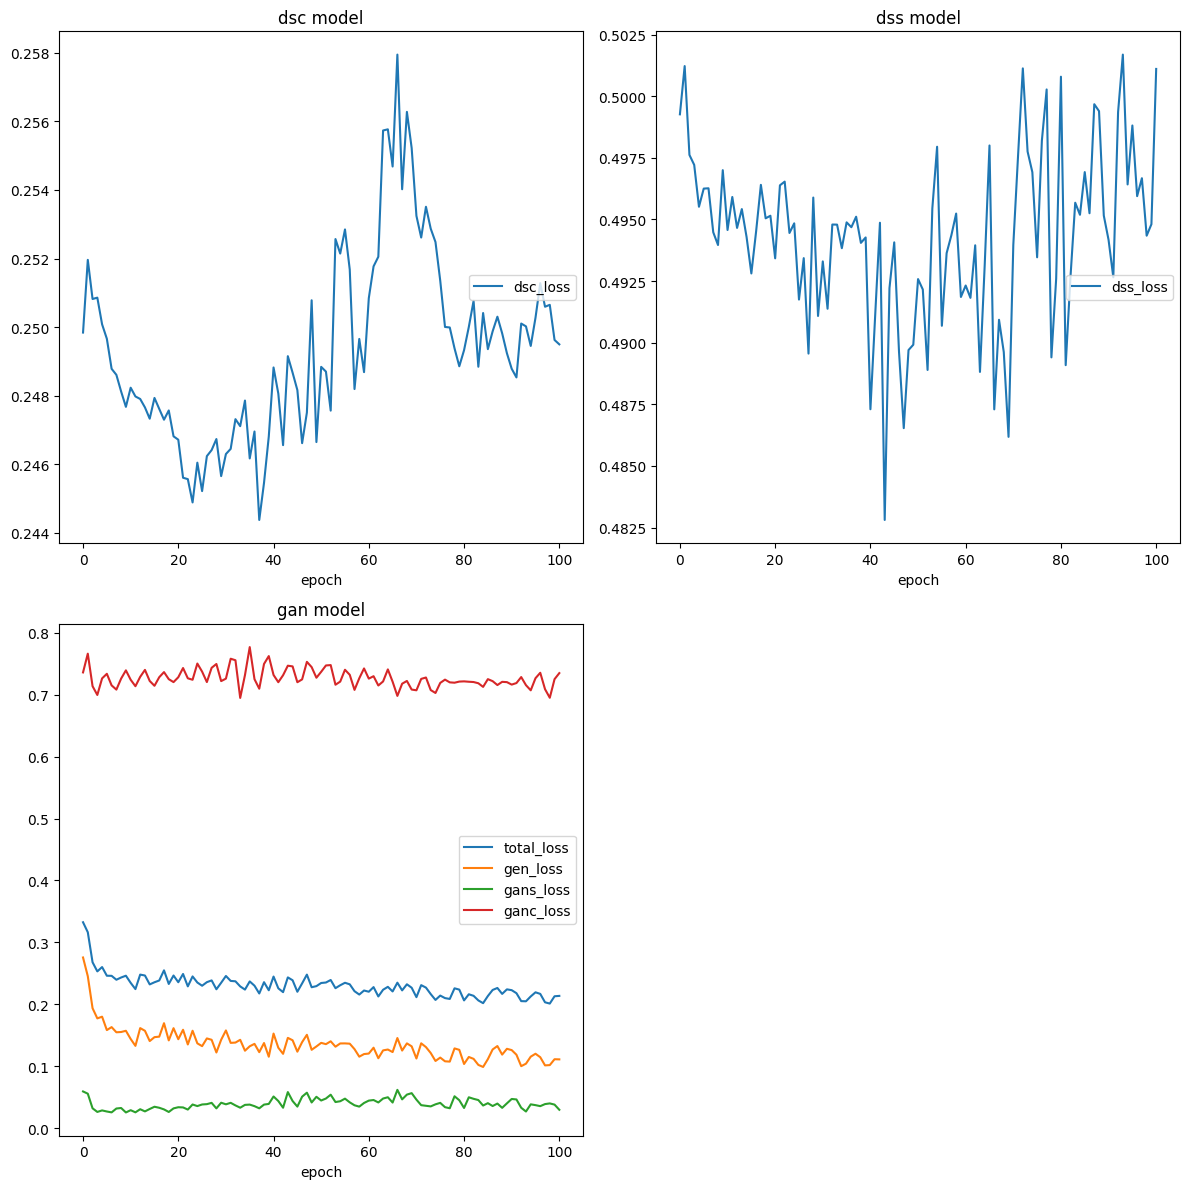

INFO:__main__:>> Saved : plot_101.png , model_101.h5 


In [4]:

dataset = load_pixel_metrics(config.GAN_DATASET_DIR)
train(g_model, dataset, config.GAN_EPOCHS, config.GAN_BATCH_SIZE)



In [5]:
import config

In [6]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g

def defing_generator(latent_size, image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    content_image = Input(shape=image_shape)
    style_image = Input(shape=image_shape)
    # stack content and style images
    stacked_layer = Concatenate()([content_image, style_image])
    #encoder model
    e1 = define_encoder_block(stacked_layer, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e6)
    b = ReLU()(b)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(b, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    #output layer
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(inputs=[content_image, style_image], outputs=out_image, name='generator')
    return model

g_model = defing_generator(config.GAN_LATENT_SIZE, config.IMAGE_SHAPE)
#tf.keras.utils.plot_model(g_model, show_shapes=True)

def define_cnt_descriminator(image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    #content image input
    in_cnt_image = Input(shape=image_shape)
    #transfer image input 
    in_tr_image = Input(shape=image_shape)
    #concatnate image channel-wise
    merged = Concatenate()([in_cnt_image, in_tr_image])
    # c64
    d = Conv2D(64, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # c128
    d = Conv2D(128, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c256
    d = Conv2D(256, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c512
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    #define model
    model = Model(inputs=[in_cnt_image, in_tr_image], outputs=patch_out, name='content_descriminator')
    return model

dc_model = define_cnt_descriminator()
#tf.keras.utils.plot_model(dc_model, show_shapes=True)


def define_style_descriminator(image_size=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    input_img = Input(shape=image_size)
    # C64
    d = Conv2D(64, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(input_img)
    d = LeakyReLU(alpha=0.2)(d)
	# C128
    d = Conv2D(128, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	# C256
    d = Conv2D(256, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # flatten
    flt = Flatten()(d)
    # linear logits layer
    output = Dense(1)(flt)
    #build and compile the model
    model = Model(inputs=input_img, outputs=output, name='style_descriminator')
    return model

ds_model = define_style_descriminator()
#tf.keras.utils.plot_model(ds_model, show_shapes=True)


def define_gan(g_model, dc_model, ds_model, image_shape=(128, 128, 3)):
    for layer in dc_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    
    for layer in ds_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # input layer for GAN model
    cnt_img = Input(shape=image_shape)
    style_img = Input(shape=image_shape)
    # generator model
    gen_out = g_model([cnt_img, style_img])
    # style descriminator model
    dss_out = ds_model(style_img)
    dst_out = ds_model(gen_out)
    # content descriminator model
    cnt_out = dc_model([cnt_img, gen_out])
    model = Model(inputs=[cnt_img, style_img], outputs=[gen_out,  dss_out, dst_out, cnt_out])
    return model

gan_model = define_gan(g_model, dc_model, ds_model)
#tf.keras.utils.plot_model(gan_model, show_shapes=True)


def pairWiseRankingLoss(y_ref, y_style, label):
    m  = tf.cast(tf.broadcast_to(1, shape=y_ref.shape), dtype=tf.float32)
    u  = tf.cast(tf.broadcast_to(0, shape=y_ref.shape), dtype=tf.float32)
    i  = tf.cast(tf.broadcast_to(1, shape=y_ref.shape), dtype=tf.float32)
    y = tf.cast(label[..., tf.newaxis], dtype=tf.float32)
    dist = tf.norm(y_ref-y_style, ord='euclidean', axis=-1, keepdims=True)
    loss = y*dist + (i-y)*tf.reduce_max(tf.stack([u,m-dist]), axis=0)
    return tf.cast(tf.reduce_mean(loss), dtype=tf.float32)

def ganLoss(dss_loss, dsc_loss, gen_loss):
    gan_alpha = config.GAN_ALPHA
    gan_beta = config.GAN_BETA
    one = 1

    tot_loss = gan_alpha*(gan_beta*dss_loss+(one-gan_beta)*dsc_loss)+(one-gan_alpha)*gen_loss
    return tot_loss

dscLoss = tf.keras.losses.BinaryCrossentropy()
cntLoss = tf.keras.losses.KLDivergence()

gan_opt = tf.keras.optimizers.Adamax(lr=0.002)


@tf.function
def gan_train_step(ref_in, style_in, trans_in,cnt_true, style_true):
    with tf.GradientTape() as tape:
        gen_out, dss_out, dst_out, cnt_out = gan_model([ref_in, style_in])
        dss_loss = pairWiseRankingLoss(dss_out, dst_out, style_true)
        dsc_loss = tf.cast(dscLoss(cnt_true, cnt_out), dtype=tf.float32)
        gen_loss = tf.cast(tf.math.abs(cntLoss(trans_in, gen_out)), dtype=tf.float32)
        total_loss = ganLoss(dss_loss, dsc_loss, gen_loss)
        
    #total_loss = add(add(multiply(gan_beta, dss_loss), multiply(subtract(one, gan_beta), dsc_loss)), multiply(subtract(one, gan_alpha), gen_loss))    
    #total_loss =  gan_alpha*(gan_beta*dss_loss+(one-gan_beta)*dsc_loss)+(one-gan_alpha)*gen_loss
    grads = tape.gradient(total_loss, gan_model.trainable_weights)
    gan_opt.apply_gradients(zip(grads, gan_model.trainable_weights))
    return total_loss, dss_loss, dsc_loss, gen_loss

ds_opt = tf.keras.optimizers.Adam(lr=0.02)

@tf.function
def ds_train_step(style_in, trans_in, label_in):
    with tf.GradientTape() as tape:
        ref_out = ds_model(style_in)
        trans_out = ds_model(trans_in)
        loss = pairWiseRankingLoss(ref_out, trans_out, label_in)
    grads = tape.gradient(loss, ds_model.trainable_weights)
    ds_opt.apply_gradients(zip(grads, ds_model.trainable_weights))
    #train_metrics.update_state(ref_out, style_out, label_in)
    return loss


dc_opt = tf.keras.optimizers.Adam(lr=0.02)

@tf.function
def dc_train_step(cnt_in, trans_in, label_in):
    with tf.GradientTape() as tape:
        logits = dc_model([cnt_in, trans_in])
        loss = cntLoss(label_in, logits)
    grads = tape.gradient(loss, dc_model.trainable_weights)
    dc_opt.apply_gradients(zip(grads, dc_model.trainable_weights))
    #train_metrics.update_state(ref_out, style_out, label_in)
    return loss


def load_pixel_metrics(filename):
    full_mat = np.load(filename)
    style_pixels = (full_mat['style']-127.5)/127.5
    content_pixels = (full_mat['cotent']-127.5)/127.5
    transfer_mat  = (full_mat['transfers']-127.5)/127.5
    return style_pixels, content_pixels, transfer_mat

def generate_real_samples(dataset, n_samples, patch_shape):
    style, content, trans = dataset
    cnt_idxs = random.sample(range(style.shape[1]), n_samples)
    style_idxs = np.random.randint(0, style.shape[0], n_samples)

    cnt_pixels = content[cnt_idxs]
    style_pixels = style[style_idxs]
    mat_pixels = trans[style_idxs, cnt_idxs, ...]

    y_dc = ones((n_samples, patch_shape, patch_shape, 1))
    y_ds = ones((n_samples))
    return [cnt_pixels, style_pixels, mat_pixels], y_dc, y_ds

def generate_fake_samples(g_model, samples, patch_shape):
    cnt_img, style_img = samples
    X = g_model([cnt_img, style_img])
    y_dc = zeros((len(X), patch_shape, patch_shape, 1))
    y_ds = zeros((len(X)))
    return X, y_dc, y_ds

def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_cnt, X_stl, X_trn], _, _ = generate_real_samples(dataset, n_samples, 1)
    X_fake, _, _ = generate_fake_samples(g_model, [X_cnt, X_stl], 1)
    #rescale pixels values
    X_cnt = (X_cnt+1)/2.0
    X_stl = (X_stl+1)/2.0
    X_fake = (X_fake+1)/2.0
    # plot samples
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_cnt[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_stl[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + 2*n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fake[i])
    # save result image 
    filename = f'plot_{step+1}.png'
    pyplot.savefig(os.path.join(config.GAN_LOG_DIR,filename))
    pyplot.close()
    # save model checkpoint
    model_filename = f'model_{step+1}.h5'
    g_model.save(os.path.join(config.GAN_LOG_DIR,model_filename))
    logger.info(f">> Saved : {filename} , {model_filename} ")


def train(g_model, dataset, n_epoch=100, batch_size=16):
    n_patch = dc_model.output_shape[1]
    batch_per_epoch = (dataset[1].shape[0]*(dataset[1].shape[1]//2))//batch_size
    n_steps = n_epoch*batch_per_epoch
    plotlosses = PlotLosses(outputs=[MatplotlibPlot()], groups={'dss model' : ['dss_loss'], 'dsc model' : ['dsc_loss'], 'gan model' : ['total_loss', 'gen_loss', 'gans_loss', 'ganc_loss']})

    save_interval = 10
    log_interval = 1

    for i in range(n_steps):
        [X_cnt, X_stl, X_trn], ydc_real, yds_real = generate_real_samples(dataset, batch_size, n_patch)
        X_fake_trn, ydc_fake, yds_fake = generate_fake_samples(g_model, [X_cnt, X_stl], n_patch)
        # train style descriminator
        usXds_stl = np.concatenate((X_stl, X_stl))
        usXds_trn = np.concatenate((X_trn, X_fake_trn))
        usysd = np.concatenate((yds_real, yds_fake))
        Xds_stl, Xds_trn, yds = shuffle(usXds_stl, usXds_trn, usysd)
        ds_loss = ds_train_step(Xds_stl, Xds_trn, yds)
        #ds_loss2 = ds_train_step(X_stl, X_fake_trn, yds_fake)
        #train content descriminator
        usXdc_cnt = np.concatenate((X_cnt, X_cnt))
        usXdc_trn = np.concatenate((X_trn, X_fake_trn))
        usydc = np.concatenate((ydc_real, ydc_fake))
        Xdc_cnt, Xdc_trn, ydc = shuffle(usXdc_cnt, usXdc_trn, usydc)
        dc_loss = dc_train_step(Xdc_cnt, Xdc_trn, ydc)
        #dc_loss2 = dc_train_step(X_cnt, X_fake_trn, ydc_fake)
        #train GAN model
        gan_total_loss, gan_dss_loss, gan_dsc_loss, gen_loss = gan_train_step(X_cnt, X_stl, X_trn, ydc_real, yds_real)

        logger.info(f'[{i}/{n_steps}] : style descriminator total loss : {ds_loss} \n content descriminator total loss : {dc_loss} \n GAN total loss : {gan_total_loss} | GAN dss loss : {gan_dss_loss} | GAN dsc loss : {gan_dsc_loss}')
        # if (i+1) % (batch_per_epoch*log_interval) == 0:
        #     plotlosses.update({
        #         'dss_loss' : ds_loss,
        #         'dsc_loss' : dc_loss,
        #         'total_loss' : gan_total_loss,
        #         'gen_loss' : gen_loss,
        #         'gans_loss' : gan_dss_loss,
        #         'ganc_loss' : gan_dsc_loss
        #     })
        #     plotlosses.send()
        plotlosses.update({
                'dss_loss' : ds_loss,
                'dsc_loss' : dc_loss,
                'total_loss' : gan_total_loss,
                'gen_loss' : gen_loss,
                'gans_loss' : gan_dss_loss,
                'ganc_loss' : gan_dsc_loss
            })
        plotlosses.send()
        if (i+1) % (batch_per_epoch*save_interval) == 0:
            summarize_performance(i, g_model, dataset)
        if i == 100:
            summarize_performance(i, g_model, dataset)
            break



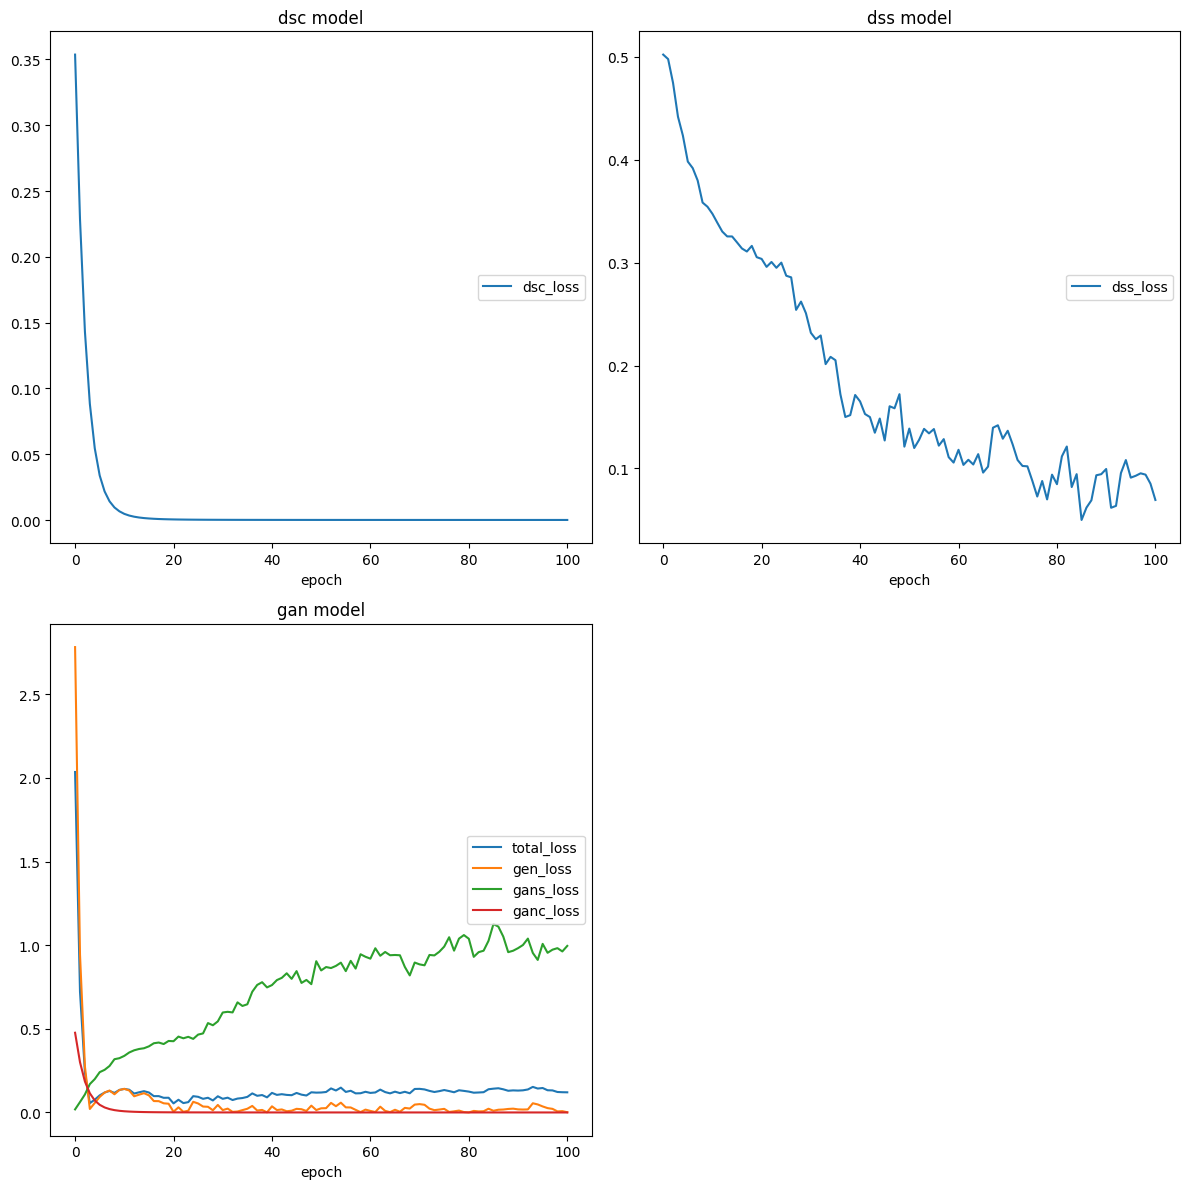

INFO:__main__:>> Saved : plot_101.png , model_101.h5 


In [7]:

dataset = load_pixel_metrics(config.GAN_DATASET_DIR)
train(g_model, dataset, config.GAN_EPOCHS, config.GAN_BATCH_SIZE)



In [8]:
import config

In [9]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g

def defing_generator(latent_size, image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    content_image = Input(shape=image_shape)
    style_image = Input(shape=image_shape)
    # stack content and style images
    stacked_layer = Concatenate()([content_image, style_image])
    #encoder model
    e1 = define_encoder_block(stacked_layer, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e6)
    b = ReLU()(b)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(b, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    #output layer
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(inputs=[content_image, style_image], outputs=out_image, name='generator')
    return model

g_model = defing_generator(config.GAN_LATENT_SIZE, config.IMAGE_SHAPE)
#tf.keras.utils.plot_model(g_model, show_shapes=True)

def define_cnt_descriminator(image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    #content image input
    in_cnt_image = Input(shape=image_shape)
    #transfer image input 
    in_tr_image = Input(shape=image_shape)
    #concatnate image channel-wise
    merged = Concatenate()([in_cnt_image, in_tr_image])
    # c64
    d = Conv2D(64, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # c128
    d = Conv2D(128, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c256
    d = Conv2D(256, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c512
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    #define model
    model = Model(inputs=[in_cnt_image, in_tr_image], outputs=patch_out, name='content_descriminator')
    return model

dc_model = define_cnt_descriminator()
#tf.keras.utils.plot_model(dc_model, show_shapes=True)


def define_style_descriminator(image_size=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    input_img = Input(shape=image_size)
    # C64
    d = Conv2D(64, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(input_img)
    d = LeakyReLU(alpha=0.2)(d)
	# C128
    d = Conv2D(128, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	# C256
    d = Conv2D(256, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # flatten
    flt = Flatten()(d)
    # linear logits layer
    output = Dense(1)(flt)
    #build and compile the model
    model = Model(inputs=input_img, outputs=output, name='style_descriminator')
    return model

ds_model = define_style_descriminator()
#tf.keras.utils.plot_model(ds_model, show_shapes=True)


def define_gan(g_model, dc_model, ds_model, image_shape=(128, 128, 3)):
    for layer in dc_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    
    for layer in ds_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # input layer for GAN model
    cnt_img = Input(shape=image_shape)
    style_img = Input(shape=image_shape)
    # generator model
    gen_out = g_model([cnt_img, style_img])
    # style descriminator model
    dss_out = ds_model(style_img)
    dst_out = ds_model(gen_out)
    # content descriminator model
    cnt_out = dc_model([cnt_img, gen_out])
    model = Model(inputs=[cnt_img, style_img], outputs=[gen_out,  dss_out, dst_out, cnt_out])
    return model

gan_model = define_gan(g_model, dc_model, ds_model)
#tf.keras.utils.plot_model(gan_model, show_shapes=True)


def pairWiseRankingLoss(y_ref, y_style, label):
    m  = tf.cast(tf.broadcast_to(1, shape=y_ref.shape), dtype=tf.float32)
    u  = tf.cast(tf.broadcast_to(0, shape=y_ref.shape), dtype=tf.float32)
    i  = tf.cast(tf.broadcast_to(1, shape=y_ref.shape), dtype=tf.float32)
    y = tf.cast(label[..., tf.newaxis], dtype=tf.float32)
    dist = tf.norm(y_ref-y_style, ord='euclidean', axis=-1, keepdims=True)
    loss = y*dist + (i-y)*tf.reduce_max(tf.stack([u,m-dist]), axis=0)
    return tf.cast(tf.reduce_mean(loss), dtype=tf.float32)

def ganLoss(dss_loss, dsc_loss, gen_loss):
    gan_alpha = config.GAN_ALPHA
    gan_beta = config.GAN_BETA
    one = 1

    tot_loss = gan_alpha*(gan_beta*dss_loss+(one-gan_beta)*dsc_loss)+(one-gan_alpha)*gen_loss
    return tot_loss

dscLoss = tf.keras.losses.BinaryCrossentropy()
cntLoss = tf.keras.losses.MeanAbsoluteError()

gan_opt = tf.keras.optimizers.Adamax(lr=0.002)


@tf.function
def gan_train_step(ref_in, style_in, trans_in,cnt_true, style_true):
    with tf.GradientTape() as tape:
        gen_out, dss_out, dst_out, cnt_out = gan_model([ref_in, style_in])
        dss_loss = pairWiseRankingLoss(dss_out, dst_out, style_true)
        dsc_loss = tf.cast(dscLoss(cnt_true, cnt_out), dtype=tf.float32)
        gen_loss = tf.cast(tf.math.abs(cntLoss(trans_in, gen_out)), dtype=tf.float32)
        total_loss = ganLoss(dss_loss, dsc_loss, gen_loss)
        
    #total_loss = add(add(multiply(gan_beta, dss_loss), multiply(subtract(one, gan_beta), dsc_loss)), multiply(subtract(one, gan_alpha), gen_loss))    
    #total_loss =  gan_alpha*(gan_beta*dss_loss+(one-gan_beta)*dsc_loss)+(one-gan_alpha)*gen_loss
    grads = tape.gradient(total_loss, gan_model.trainable_weights)
    gan_opt.apply_gradients(zip(grads, gan_model.trainable_weights))
    return total_loss, dss_loss, dsc_loss, gen_loss

ds_opt = tf.keras.optimizers.Adam(lr=0.02)

@tf.function
def ds_train_step(style_in, trans_in, label_in):
    with tf.GradientTape() as tape:
        ref_out = ds_model(style_in)
        trans_out = ds_model(trans_in)
        loss = pairWiseRankingLoss(ref_out, trans_out, label_in)
    grads = tape.gradient(loss, ds_model.trainable_weights)
    ds_opt.apply_gradients(zip(grads, ds_model.trainable_weights))
    #train_metrics.update_state(ref_out, style_out, label_in)
    return loss


dc_opt = tf.keras.optimizers.Adam(lr=0.02)

@tf.function
def dc_train_step(cnt_in, trans_in, label_in):
    with tf.GradientTape() as tape:
        logits = dc_model([cnt_in, trans_in])
        loss = cntLoss(label_in, logits)
    grads = tape.gradient(loss, dc_model.trainable_weights)
    dc_opt.apply_gradients(zip(grads, dc_model.trainable_weights))
    #train_metrics.update_state(ref_out, style_out, label_in)
    return loss


def load_pixel_metrics(filename):
    full_mat = np.load(filename)
    style_pixels = (full_mat['style']-127.5)/127.5
    content_pixels = (full_mat['cotent']-127.5)/127.5
    transfer_mat  = (full_mat['transfers']-127.5)/127.5
    return style_pixels, content_pixels, transfer_mat

def generate_real_samples(dataset, n_samples, patch_shape):
    style, content, trans = dataset
    cnt_idxs = random.sample(range(style.shape[1]), n_samples)
    style_idxs = np.random.randint(0, style.shape[0], n_samples)

    cnt_pixels = content[cnt_idxs]
    style_pixels = style[style_idxs]
    mat_pixels = trans[style_idxs, cnt_idxs, ...]

    y_dc = ones((n_samples, patch_shape, patch_shape, 1))
    y_ds = ones((n_samples))
    return [cnt_pixels, style_pixels, mat_pixels], y_dc, y_ds

def generate_fake_samples(g_model, samples, patch_shape):
    cnt_img, style_img = samples
    X = g_model([cnt_img, style_img])
    y_dc = zeros((len(X), patch_shape, patch_shape, 1))
    y_ds = zeros((len(X)))
    return X, y_dc, y_ds

def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_cnt, X_stl, X_trn], _, _ = generate_real_samples(dataset, n_samples, 1)
    X_fake, _, _ = generate_fake_samples(g_model, [X_cnt, X_stl], 1)
    #rescale pixels values
    X_cnt = (X_cnt+1)/2.0
    X_stl = (X_stl+1)/2.0
    X_fake = (X_fake+1)/2.0
    # plot samples
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_cnt[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_stl[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + 2*n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fake[i])
    # save result image 
    filename = f'plot_{step+1}.png'
    pyplot.savefig(os.path.join(config.GAN_LOG_DIR,filename))
    pyplot.close()
    # save model checkpoint
    model_filename = f'model_{step+1}.h5'
    g_model.save(os.path.join(config.GAN_LOG_DIR,model_filename))
    logger.info(f">> Saved : {filename} , {model_filename} ")


def train(g_model, dataset, n_epoch=100, batch_size=16):
    n_patch = dc_model.output_shape[1]
    batch_per_epoch = (dataset[1].shape[0]*(dataset[1].shape[1]//2))//batch_size
    n_steps = n_epoch*batch_per_epoch
    plotlosses = PlotLosses(outputs=[MatplotlibPlot()], groups={'dss model' : ['dss_loss'], 'dsc model' : ['dsc_loss'], 'gan model' : ['total_loss', 'gen_loss', 'gans_loss', 'ganc_loss']})

    save_interval = 10
    log_interval = 1

    for i in range(n_steps):
        [X_cnt, X_stl, X_trn], ydc_real, yds_real = generate_real_samples(dataset, batch_size, n_patch)
        X_fake_trn, ydc_fake, yds_fake = generate_fake_samples(g_model, [X_cnt, X_stl], n_patch)
        # train style descriminator
        usXds_stl = np.concatenate((X_stl, X_stl))
        usXds_trn = np.concatenate((X_trn, X_fake_trn))
        usysd = np.concatenate((yds_real, yds_fake))
        Xds_stl, Xds_trn, yds = shuffle(usXds_stl, usXds_trn, usysd)
        ds_loss = ds_train_step(Xds_stl, Xds_trn, yds)
        #ds_loss2 = ds_train_step(X_stl, X_fake_trn, yds_fake)
        #train content descriminator
        usXdc_cnt = np.concatenate((X_cnt, X_cnt))
        usXdc_trn = np.concatenate((X_trn, X_fake_trn))
        usydc = np.concatenate((ydc_real, ydc_fake))
        Xdc_cnt, Xdc_trn, ydc = shuffle(usXdc_cnt, usXdc_trn, usydc)
        dc_loss = dc_train_step(Xdc_cnt, Xdc_trn, ydc)
        #dc_loss2 = dc_train_step(X_cnt, X_fake_trn, ydc_fake)
        #train GAN model
        gan_total_loss, gan_dss_loss, gan_dsc_loss, gen_loss = gan_train_step(X_cnt, X_stl, X_trn, ydc_real, yds_real)

        logger.info(f'[{i}/{n_steps}] : style descriminator total loss : {ds_loss} \n content descriminator total loss : {dc_loss} \n GAN total loss : {gan_total_loss} | GAN dss loss : {gan_dss_loss} | GAN dsc loss : {gan_dsc_loss}')
        # if (i+1) % (batch_per_epoch*log_interval) == 0:
        #     plotlosses.update({
        #         'dss_loss' : ds_loss,
        #         'dsc_loss' : dc_loss,
        #         'total_loss' : gan_total_loss,
        #         'gen_loss' : gen_loss,
        #         'gans_loss' : gan_dss_loss,
        #         'ganc_loss' : gan_dsc_loss
        #     })
        #     plotlosses.send()
        plotlosses.update({
                'dss_loss' : ds_loss,
                'dsc_loss' : dc_loss,
                'total_loss' : gan_total_loss,
                'gen_loss' : gen_loss,
                'gans_loss' : gan_dss_loss,
                'ganc_loss' : gan_dsc_loss
            })
        plotlosses.send()
        if (i+1) % (batch_per_epoch*save_interval) == 0:
            summarize_performance(i, g_model, dataset)
        if i == 100:
            summarize_performance(i, g_model, dataset)
            break



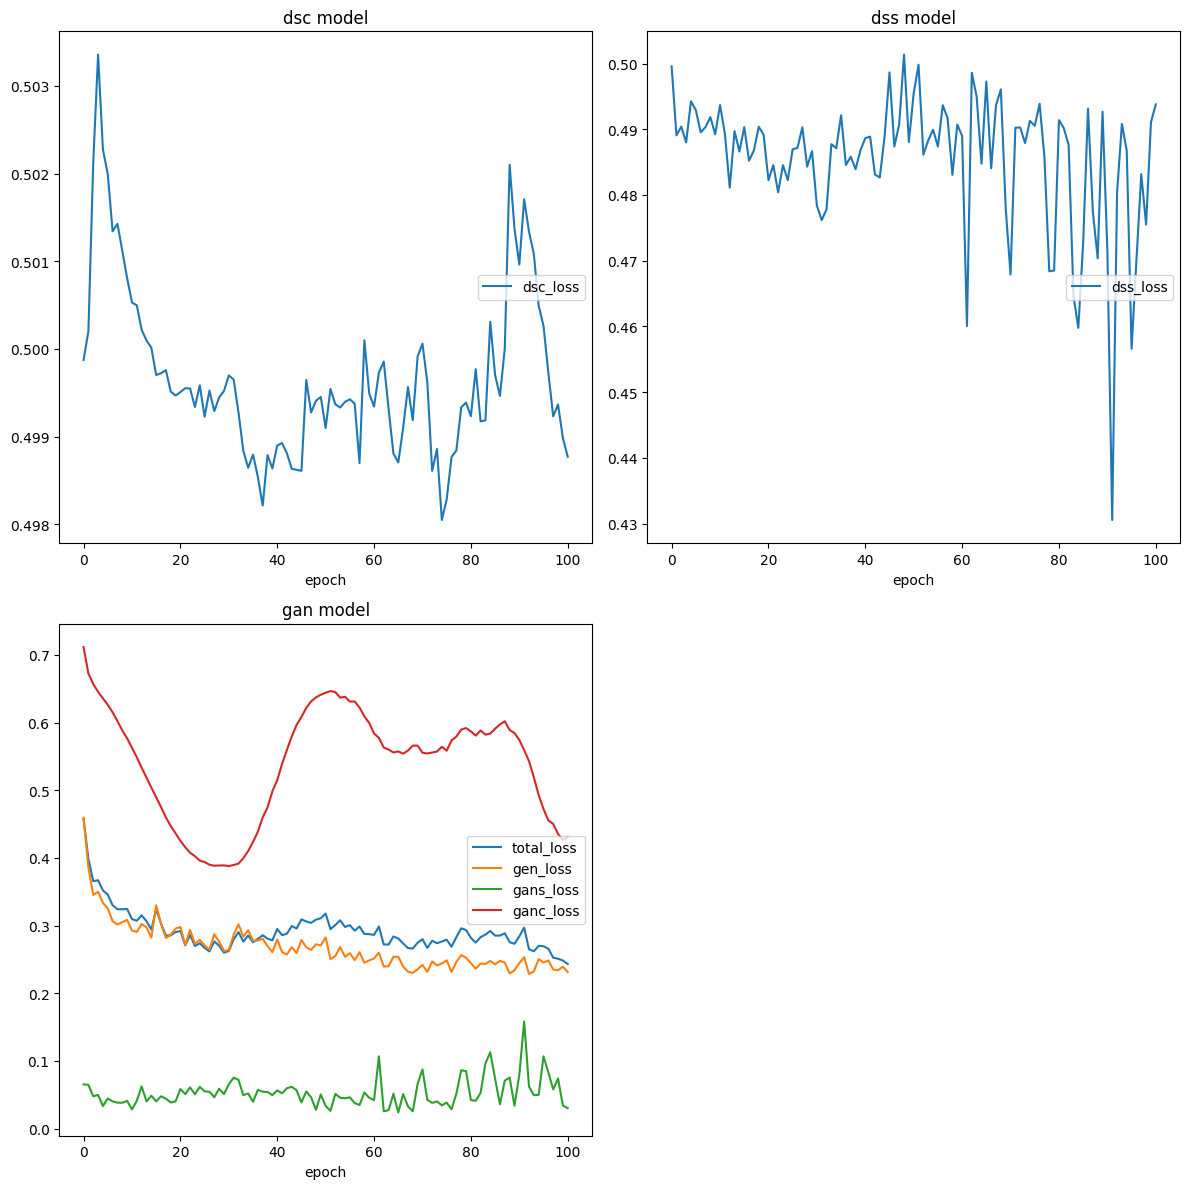

INFO:__main__:>> Saved : plot_101.png , model_101.h5 


In [10]:

dataset = load_pixel_metrics(config.GAN_DATASET_DIR)
train(g_model, dataset, config.GAN_EPOCHS, config.GAN_BATCH_SIZE)

